# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

In [1]:
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

You should consider upgrading via the 'C:\Users\argon\Documents\UTS\AI Capstone\AI Project\DeepNN\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\argon\Documents\UTS\AI Capstone\AI Project\DeepNN\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\argon\Documents\UTS\AI Capstone\AI Project\DeepNN\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# # Anything above 2.10 is not supported on the GPU on Windows Native
# !pip install "tensorflow<2.11"




==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.4





Solving environment: ...working... done

# All requested packages already installed.



You should consider upgrading via the 'C:\Users\argon\Documents\UTS\AI Capstone\AI Project\DeepNN\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
# !pip list
# !pip install -q seaborn

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
asttokens                    2.4.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.1.3
executing                    1.2.0
flatbuffers                  23.5.26
fonttools                    4.42.1
gast                         0.4.0
google-auth                  2.23.1
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.58.0
h5py                         3.9.0
idna                         3.4
importlib-metadata           6.8.0
importlib-resources          6.1.0
ipy

You should consider upgrading via the 'C:\Users\argon\Documents\UTS\AI Capstone\AI Project\DeepNN\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\argon\Documents\UTS\AI Capstone\AI Project\DeepNN\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(precision=3, suppress=True)

In [2]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mae']), 
             label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
             label = 'Val')
    plt.legend()
    # plt.ylim([0,max(history.history['val_mae']) + 1])
    
def plot_prediction(test_labels, test_predictions):
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])
    
    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 
Temperature is in celcius
Voltage is in volts
Current is in Amps

In [3]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [4]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [5]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [6]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [7]:
df['ambient_temperature'].nunique()

1

# Machine Learning (LSTM)

Now we begin to build our Long Short Term Memory Network

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Bidirectional
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import warnings

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
prep_df = df.drop(['datetime', 'ambient_temperature'], axis = 1)

In [13]:
X = df[["cycle", "voltage_measured", "current_measured", "temperature_measured", "current", "voltage", "time"]]
y = df["capacity"]

## Normalisation

Here we will normalise the values to give equal weight to each feature

In [14]:
# Normalize the input features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
# Reshape data for the RNN
X = X.reshape(X.shape[0], 1, X.shape[1])

### Splitting the Dataset for training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regression with LSTM

In [ ]:
def create_BiDirLSTM():
    model = keras.Sequential()
    model.add(Bidirectional(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh')))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Capacity]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [ ]:
bdlstm_model = create_BiDirLSTM()

bdlstm_model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

bdlstm_model.summary()

In [ ]:
epochs = 40
checkpoint_filepath = os.path.join('checkpoints','BiDirLSTM_01{epoch:02d}-{val_loss:.4f}.h5')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

In [ ]:
%%time
history.append(bdlstm_model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = model_checkpoint_callback))

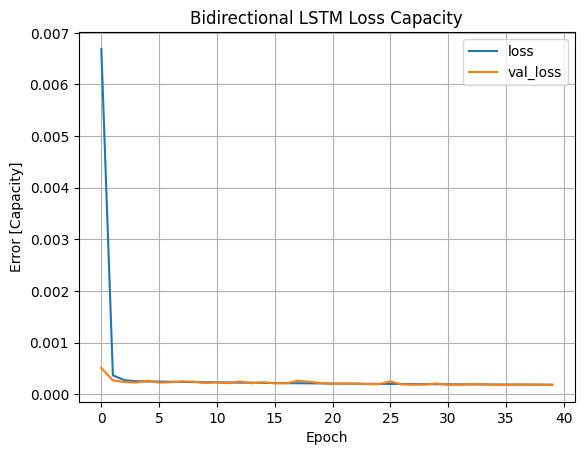

In [31]:
plot_loss(history[-1], "Bidirectional LSTM Loss Capacity")

In [17]:
model_path = os.path.join("models","BiDirLSTM_01.keras")

In [38]:
bdlstm_model.save(model_path)

### Performance

In [18]:
bdlstm_model = tf.keras.models.load_model(model_path)

In [19]:
# pd.DataFrame(test_results, index=['Mean absolute error [capacity]']).T

### Make Predictions

In [20]:
test_predictions = bdlstm_model.predict(X_test).flatten()

3675/3675 [==============================] - 21s 4ms/step


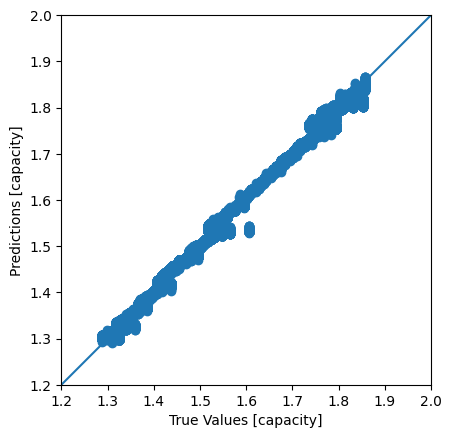

In [21]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [capacity]')
plt.ylabel('Predictions [capacity]')
lims = [1.2, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

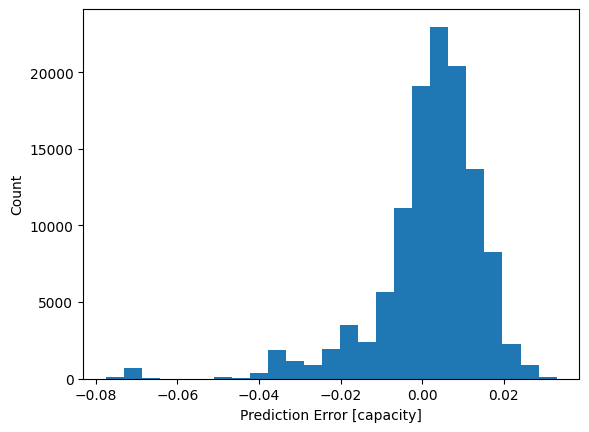

In [22]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [capacity]')
_ = plt.ylabel('Count')

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [24]:
# Calculate regression metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.00017953736258969144
Root Mean Squared Error (RMSE): 0.01339915529388668
Mean Absolute Error (MAE): 0.009640059033227134
R-squared (R2): 0.9939211326436099
